<a href="https://colab.research.google.com/github/saketshubh/ProgrammingAssignment2/blob/master/JBM_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description**: Training an image classifier for identifying defects in automobile parts

**Approach**: The most important aspect of any Machine Learning Problem is to understand the business landscape and designing the analytics architecture wrt the business objectives and potential value realization.

### The first step is to gather the data and create the backbone for analytics process. The raw dataset provided for this use case has part images for different models. There are 64 different types of parts' images with a total of *508 images*: The images have been classified into *Good (350 count)* and *Bad (108)* depending on the cracks/ defects/ rust issues etc.

Below would be the flow of the various steps to be undertaken for the **end-to-end Machine Learning Model Development**:

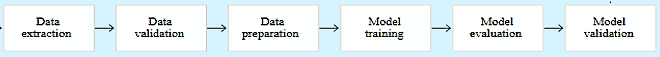

---

We would be using a supervised Deep Learning model (Convolutional Neural Network) to start with the model building process


**Importing the required libraries** - Tensorflow, Keras, numpy, Scikitlearn etc. We will also use Matplotlib and Seaborn for visualizing our dataset to gain a better understanding of the images we are going to be handling

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

Loading the data - Writing a function called get_data() that makes it easier for us to create our train and validation dataset. We define the two labels ‘Good’ and ‘Bad’ will be used further. 

In [3]:
labels = ['Good', 'Bad']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

**Data upload** - The data has been uploaded to Google Drive to seamlessly connect with Colaboratory. Two folders for Good and Bad have been created which will be used to create our training data as per the above function.

[Training Data Link](https://drive.google.com/drive/folders/13IxQI1XBaBfdyypZWfnKxfR_TqCoQgJs?usp=sharing)

### Fetching our train and validation datasets. 

For the simplicity of our model training, we would be using the complete dataset for train and test/validation (Ideally there should be a 80/20 partition, however to overcome the small quantum of data we will be using the entire data for training and testing.) A smaller subset of the same data can also be used for test/ validation.

In [4]:
train = get_data('/content/drive/MyDrive/Colab Notebooks/Datasets/Model Data')
#val = get_data('/content/drive/MyDrive/Colab Notebooks/Datasets/Sample')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [5]:
val = get_data('/content/drive/MyDrive/Colab Notebooks/Datasets/Model Data')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


**Visualizing the data** - using seaborn to plot the number of images in both the classes and check what the output looks like.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


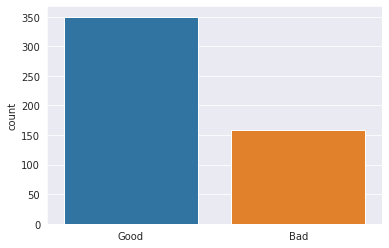

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Good")
    else:
        l.append("Bad")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'Good')

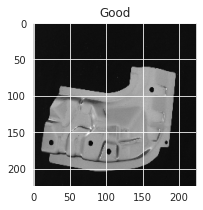

In [9]:
plt.figure(figsize = (3,3))
plt.imshow(train[50][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'Bad')

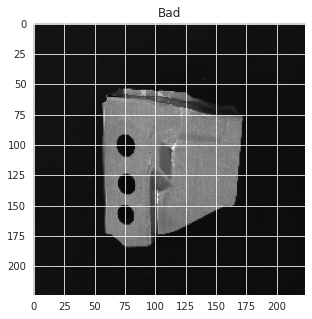

In [11]:
plt.figure(figsize = (5,5))
plt.imshow(train[-10][0])
plt.title(labels[train[-1][1]])

**Data preprocessing**: We need to perform some Data Preprocessing and Data Augmentation before we can proceed with building the model

In [14]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

#Data augmentation on the train data:-

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

**Defining the Model** - CNN with 3 layers

Designing 3 Convolutional layers followed by max-pooling layers. A dropout layer is added after the 3rd maxpool operation to avoid overfitting.

We compile the model using Adam optimizer and SparseCategoricalCrossentropy as the loss function. We are using a lower learning rate of 0.00001 for a smoother curve.

In [13]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0

In [15]:
opt = Adam(lr=0.00001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])


**Hyperparameter tuning** - training the model for 30 epochs. Multiple iterations need to be tried for getting the best fit model

In [ ]:
#Epochs = 30
history = model.fit(x_train,y_train,epochs = 30 , validation_data = (x_val, y_val))

Epoch 1/200
16/16 [==============================] - 38s 2s/step - loss: 0.6629 - accuracy: 0.6712 - val_loss: 0.6305 - val_accuracy: 0.6890
Epoch 2/200
16/16 [==============================] - 37s 2s/step - loss: 0.6158 - accuracy: 0.7092 - val_loss: 0.6236 - val_accuracy: 0.6890
Epoch 3/200
16/16 [==============================] - 37s 2s/step - loss: 0.6227 - accuracy: 0.6912 - val_loss: 0.6177 - val_accuracy: 0.6890
Epoch 4/200
16/16 [==============================] - 37s 2s/step - loss: 0.6243 - accuracy: 0.6865 - val_loss: 0.6109 - val_accuracy: 0.6890
Epoch 5/200
16/16 [==============================] - 37s 2s/step - loss: 0.6185 - accuracy: 0.6863 - val_loss: 0.6032 - val_accuracy: 0.6890
Epoch 6/200
16/16 [==============================] - 39s 2s/step - loss: 0.6180 - accuracy: 0.6726 - val_loss: 0.5947 - val_accuracy: 0.6890
Epoch 7/200
16/16 [==============================] - 37s 2s/step - loss: 0.5861 - accuracy: 0.7064 - val_loss: 0.5860 - val_accuracy: 0.6890
Epoch 8/200
1

**Evaluating the result**: Training and Testing Accuracy

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Confusion Matrix** for accuracy and precision

In [ ]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_val, predictions, target_names = ['Rugby (Class 0)','Soccer (Class 1)']))


**Summary**: The simple CNN model was able to achieve an accuracy of ~90%. With some further hyperparameter tuning and advanced model, we might be able to achieve further increase in the accuracy. However we would need to make sure the model doesn't overfit and there is a consistent output coming up in both training and test data sets.